Demo - Air Quality

$$
\mathbf{x} \in \mathbb{R}^{D}
$$

where `D = lat x lon x time`

In [18]:
from urllib.request import urlopen
import bayesnewton
import objax
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pandas as pd
from sklearn.preprocessing import StandardScaler
# from convertbng.util import convert_bng
import time
import zipfile
import pickle


## Data

In [11]:
url = "https://zenodo.org/record/4531304/files/data.zip?download=1f"
with open("./data_dl.zip", "wb") as f:
    f.write(urlopen(url).read())

In [13]:
with zipfile.ZipFile("./data_dl.zip", 'r') as zip_ref:
    zip_ref.extractall("./downloaded_data")

In [32]:


ind = 0
train_data = pickle.load(open("./downloaded_data/data/air_quality/data/train_data_" + str(ind) + ".pickle", "rb"))
pred_data = pickle.load(open("./downloaded_data/data/air_quality/data/pred_data_" + str(ind) + ".pickle", "rb"))

X = train_data['X']
Y = train_data['Y']

X_t = pred_data['test']['X']
Y_t = pred_data['test']['Y']

In [22]:
print('X: ', X.shape)

num_z_space = 30

grid = True
print(Y.shape)
print("num data points =", Y.shape[0])

X:  (155448, 3)
(155448, 1)
num data points = 155448


In [ ]:
species = 'pm10'

raw_data = pd.read_csv('../downloaded_data/air_quality/aq_data.csv')
sites_df = pd.read_csv('../downloaded_data/air_quality/laqn_sites.csv', sep=';')

In [29]:
Y.shape

(155448, 1)

In [24]:
# the sequential approach:
t = X[:, :1]
R = X[:, 1:]
t_t = X_t[:, :1]
R_t = X_t[:, 1:]


# Nt = t.shape[0]
# print("num time steps =", Nt)
# Nr = R.shape[1]
# print("num spatial points =", Nr)
# N = Y.shape[0] * Y.shape[1] * Y.shape[2]
# print("num data points =", N)

In [26]:
R.shape, R_t.shape

((155448, 2), (155448, 2))

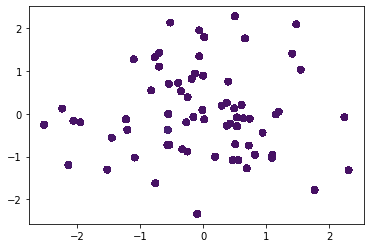

In [30]:
fig, ax = plt.subplots()

ax.scatter(R[:, 0], R[:, 1], c=Y.squeeze())

plt.show()

## Preprocessing

In [ ]:
def datetime_to_epoch(datetime):
    """
        Converts a datetime to a number
        args:
            datatime: is a pandas column
    """
    return datetime.astype('int64') // 1e9

In [ ]:
# filter sites not in london
london_box = [
    [51.279, 51.684],  # lat
    [-0.533, 0.208]  # lon
]

sites_df = sites_df[(sites_df['Latitude'] > london_box[0][0]) & (sites_df['Latitude'] < london_box[0][1])]
sites_df = sites_df[(sites_df['Longitude'] > london_box[1][0]) & (sites_df['Longitude'] < london_box[1][1])]

# merge spatial infomation to data
raw_data = raw_data.merge(sites_df, left_on='site', right_on='SiteCode')

# convert to datetimes
raw_data['date'] = pd.to_datetime(raw_data['date'])
raw_data['epoch'] = datetime_to_epoch(raw_data['date'])

# get data in date range
data_range_start = '2019/02/18 00:00:00'
data_range_end = '2019/02/25 23:59:59'  # '2019/03/11 23:59:59', '2019/02/25 23:59:59', '2019/04/17 23:59:59'

raw_data = raw_data[(raw_data['date'] >= data_range_start) & (raw_data['date'] < data_range_end)]

X = np.array(raw_data[['epoch', 'Longitude', 'Latitude']])
Y = np.array(raw_data[[species]])

# convert to easting and northings
british_national_grid_coords = convert_bng(X[:, 1], X[:, 2])
X = np.vstack([X[:, 0],
              np.array(british_national_grid_coords[0]),
              np.array(british_national_grid_coords[1])]).T


# normalise
# X = (X - np.mean(X, axis=0)) / np.std(X, axis=0)
# Y = (Y - np.nanmean(Y, axis=0)) / np.nanstd(Y, axis=0)

# standardise
# X_scaler = StandardScaler().fit(X)
R_scaler = StandardScaler().fit(X[:, 1:])
Y_scaler = StandardScaler().fit(Y)
# X = X_scaler.transform(X)
X[:, 1:] = R_scaler.transform(X[:, 1:])
X[:, 0] = (X[:, 0] - min(X[:, 0])) / (60 * 60)  # convert from seconds to hours
Y = Y_scaler.transform(Y)

grid = True
print(Y.shape)
print("num data points =", Y.shape[0])


test_ind = np.random.permutation(X.shape[0])[:X.shape[0]//10]
t_test = X[test_ind, :1]
R_test = X[test_ind, 1:]
Y_test = Y[test_ind, :]

if grid:
    # the gridded approach:
    t, R, Y = bayesnewton.utils.create_spatiotemporal_grid(X, Y)
else:
    # the sequential approach:
    t = X[:, :1]
    R = X[:, 1:]
Nt = t.shape[0]
print("num time steps =", Nt)
N = Y.shape[0] * Y.shape[1] * Y.shape[2]
print("num data points =", N)

# ttest = np.unique(X[:, 0])[:, None]

N_test = 20  # 50

# r1 = np.unique(X[:, 1])
# r2 = np.unique(X[:, 2])
X1range = max(X[:, 1]) - min(X[:, 1])
X2range = max(X[:, 2]) - min(X[:, 2])
r1 = np.linspace(min(X[:, 1]) - 0.1 * X1range, max(X[:, 1]) + 0.1 * X1range, num=N_test)
r2 = np.linspace(min(X[:, 2]) - 0.05 * X2range, max(X[:, 2]) + 0.05 * X2range, num=N_test)
rA, rB = np.meshgrid(r1, r2)
r = np.hstack((rA.reshape(-1, 1), rB.reshape(-1, 1)))  # Flattening grid for use in kernel functions
Rplot = np.tile(r, [t.shape[0], 1, 1])

## Model

In [ ]:
var_y = 1.
var_f = 1.
len_time = 5  # step size = 1 (hour)
len_space = 1  # spatial inputs normalised to around [-3, 3]

sparse = True
opt_z = True  # will be set to False if sparse=False

if sparse:
    z1 = np.linspace(np.min(X[:, 1]), np.max(X[:, 1]), num=7)
    z2 = np.linspace(np.min(X[:, 2]), np.max(X[:, 2]), num=7)
    zA, zB = np.meshgrid(z1, z2)  # Adding additional dimension to inducing points grid
    z = np.hstack((zA.reshape(-1, 1), zB.reshape(-1, 1)))  # Flattening grid for use in kernel functions
    del z1, z2, zA, zB
else:
    z = R[0, ...]

del raw_data, X, rA, rB, r, sites_df

# kern = bayesnewton.kernels.SpatioTemporalMatern52(variance=var_f,
#                                            lengthscale_time=len_time,
#                                            lengthscale_space=[len_space, len_space],
#                                            z=z,
#                                            sparse=sparse,
#                                            opt_z=opt_z,
#                                            conditional='Full')

kern_time = bayesnewton.kernels.Matern32(variance=var_f, lengthscale=len_time)
kern_space0 = bayesnewton.kernels.Matern32(variance=var_f, lengthscale=len_space)
kern_space1 = bayesnewton.kernels.Matern32(variance=var_f, lengthscale=len_space)
kern_space = bayesnewton.kernels.Separable([kern_space0, kern_space1])

kern = bayesnewton.kernels.SpatioTemporalKernel(temporal_kernel=kern_time,
                                                spatial_kernel=kern_space,
                                                z=z,
                                                sparse=sparse,
                                                opt_z=opt_z,
                                                conditional='Full')

lik = bayesnewton.likelihoods.Gaussian(variance=var_y)
# model = bayesnewton.models.VariationalGP(kernel=kern, likelihood=lik, X=X, Y=y)
model = bayesnewton.models.MarkovVariationalGP(kernel=kern, likelihood=lik, X=t, R=R, Y=Y)
# model = bayesnewton.models.InfiniteHorizonVariationalGP(kernel=kern, likelihood=lik, X=t, R=R, Y=Y)
# model = bayesnewton.models.MarkovVariationalGPMeanField(kernel=kern, likelihood=lik, X=t, R=R, Y=Y)

# Mt = 700  # num inducing points in time
# batch_size = Nt
# Z = np.linspace(np.min(t), np.max(t), Mt)[:, None]

# model = bayesnewton.models.SparseMarkovVariationalGP(kernel=kern, likelihood=lik, X=t, R=R, Y=Y, Z=Z)

lr_adam = 0.05
lr_newton = 0.5
iters = 20
opt_hypers = objax.optimizer.Adam(model.vars())
energy = objax.GradValues(model.energy, model.vars())


@objax.Function.with_vars(model.vars() + opt_hypers.vars())
def train_op():
    model.inference(lr=lr_newton)  # perform inference and update variational params
    dE, E = energy()  # compute energy and its gradients w.r.t. hypers
    opt_hypers(lr_adam, dE)
    return E


train_op = objax.Jit(train_op)

t0 = time.time()
for i in range(1, iters + 1):
    loss = train_op()
    print('iter %2d, energy: %1.4f' % (i, loss[0]))
t1 = time.time()
print('optimisation time: %2.2f secs' % (t1-t0))

# calculate posterior predictive distribution via filtering and smoothing at train & test locations:
print('calculating the posterior predictive distribution ...')
t0 = time.time()
posterior_mean, posterior_var = model.predict(X=t, R=Rplot)
nlpd = model.negative_log_predictive_density(X=t_test, R=R_test, Y=Y_test)
t1 = time.time()
print('prediction time: %2.2f secs' % (t1-t0))
print('nlpd: %2.3f' % nlpd)

z_opt = model.kernel.z.value
mu = bayesnewton.utils.transpose(posterior_mean.reshape(-1, N_test, N_test))

mu = Y_scaler.inverse_transform(mu)
Y = Y_scaler.inverse_transform(Y)

save_result = False

## Plotting

In [1]:
print('plotting ...')
cmap = cm.viridis
vmin = np.nanpercentile(Y, 1)
vmax = np.nanpercentile(Y, 99)

for time_step in range(t.shape[0]):
    print(time_step)
    f, (a0, a1) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [20, 1]})
    f.set_figheight(8)
    # f.set_figwidth(8)
    im = a0.imshow(mu[time_step].T, cmap=cmap, vmin=vmin, vmax=vmax,
                   extent=[r1[0], r1[-1], r2[0], r2[-1]], origin='lower')
    a0.scatter(R[time_step, :, 0], R[time_step, :, 1], cmap=cmap, vmin=vmin, vmax=vmax,
               c=np.squeeze(Y[time_step]), s=50, edgecolors='black')
    plt.colorbar(im, fraction=0.0348, pad=0.03, aspect=30, ax=a0)
    if sparse:
        a0.scatter(z_opt[:, 0], z_opt[:, 1], c='r', s=20, alpha=0.5)  # plot inducing inputs
    a0.set_xlim(r1[0], r1[-1])
    a0.set_ylim(r2[0], r2[-1])
    a0.set_xticks([], [])
    a0.set_yticks([], [])
    a0.set_title(species)
    # a0.set_ylabel('Latitude')
    # a0.set_xlabel('Longitude')
    a0.set_xlabel('Easting')
    a0.set_ylabel('Northing')
    a1.vlines(t[time_step] / 24, -1, 1, 'r')
    a1.set_xlabel('time (days)')
    a1.set_yticks([], [])
    a1.set_xlim(t[0] / 24, t[-1] / 24)
    # a1.set_xticks([0, 7, 14, 21])
    f.savefig('output/output_%04d.png' % time_step)
    plt.close(f)

plotting ...


NameError: name 'cm' is not defined